In [1]:
import numpy as np
import matplotlib as plt 
import seaborn as sns
import pandas as pd
import statsmodels.api as sm

plt.style.use("Solarize_Light2")

### 5. In Chapter 4, we used logistic regression to predict the probability of default using income and balance on the Default data set. We will now estimate the test error of this logistic regression model using the validation set approach. Do not forget to set a random seed before beginning your analysis.

In [2]:
default_df = pd.read_csv("data/Default.csv")
default_df.student = default_df.student.map({"Yes": 1,
                                            "No": 0})
default_df

,default,student,balance,income
0,No,0,729.526495,44361.625074
1,No,1,817.180407,12106.134700
2,No,0,1073.549164,31767.138947
3,No,0,529.250605,35704.493935
4,No,0,785.655883,38463.495879
...,...,...,...,...
9995,No,0,711.555020,52992.378914
9996,No,0,757.962918,19660.721768
9997,No,0,845.411989,58636.156984
9998,No,0,1569.009053,36669.112365


#### (a) Fit a logistic regression model that uses income and balance to predict default.

#### (b) Using the validation set approach, estimate the test error of this model. In order to do this, you must perform the following steps:
  * i. Split the sample set into a training set and a validation set.
  * ii. Fit a multiple logistic regression model using only the training observations.
  * iii. Obtain a prediction of default status for each individual in the validation set by computing the posterior probability of default for that individual, and classifying the individual to the default category if the posterior probability is greater than 0.5.
  * iv. Compute the validation set error, which is the fraction of the observations in the validation set that are misclassified.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as Logit
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(default_df[["income", "balance"]], default_df["default"], random_state=42)

logit = Logit().fit(X_train, y_train)
preds = logit.predict(X_test)
valid_error = 1 - accuracy_score(y_test, preds)
valid_error


0.027599999999999958

#### (c) Repeat the process in (b) three times, using three different splits of the observations into a training set and a validation set. Comment on the results obtained.

In [4]:
from sklearn.model_selection import cross_validate
cv = cross_validate(Logit(), default_df[["income", "balance"]], default_df["default"], cv=3)
print("Validation Errors: ", 1- cv["test_score"])

Validation Errors:  [0.02639472 0.02850285 0.03420342]


#### (d) Now consider a logistic regression model that predicts the probability of default using income, balance, and a dummy variable for student. Estimate the test error for this model using the validation set approach. Comment on whether or not including a dummy variable for student leads to a reduction in the test error rate.

In [5]:
cv = cross_validate(Logit(), default_df[["student", "income", "balance"]], default_df["default"], cv=3)
print("Validation Errors: ", 1- cv["test_score"])

Validation Errors:  [0.02639472 0.02850285 0.03420342]


Adding the student variable did not improve the validation errors.

### 6. We continue to consider the use of a logistic regression model to predict the probability of default using income and balance on the Default data set. In particular, we will now compute estimates for the standard errors of the income and balance logistic regression coefficients in two different ways: (1) using the bootstrap, and (2) using the standard formula for computing the standard errors in the glm() function. Do not forget to set a random seed before beginning your analysis.

#### (a) Using the summary() and glm() functions, determine the estimated standard errors for the coefficients associated with income and balance in a multiple logistic regression model that uses both predictors.

In [6]:
X_6 = default_df[["income", "balance"]]
X_6 = sm.add_constant(X_6)
y_6 = default_df[["default"]] == "Yes"

log_model6 = sm.Logit(y_6, X_6).fit()
log_model6.summary()

Optimization terminated successfully.
         Current function value: 0.078948
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Fri, 04 Aug 2023   Pseudo R-squ.:                  0.4594
Time:                        14:41:03   Log-Likelihood:                -789.48
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                4.541e-292
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.5405      0.435    -26.544      0.000     -12.393     -10.688
income      2.081e-05   4.99e-06      4.174      0.000     1.1e-05    3.06e-05
balance        0.0056      0.000     24.835      0.000       0.005       0.006
==============================================================================

Possibly complete quasi-separation: A fraction 0.14 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

#### (b) Write a function, boot.fn(), that takes as input the Default data set as well as an index of the observations, and that outputs the coefficient estimates for income and balance in the multiple logistic regression model.

In [7]:
def boot(X, y, index):
    
    logit = sm.Logit(y.iloc[index], X.iloc[index]).fit(disp=False)
    
    params = logit.params
    std_err = logit.bse
    
    return params.to_list()

def boot_iter(X, y, n=1000):
    index = np.random.randint(low=0, high=len(y), size=(n, len(y)))
    res = []
    
    for i, idx in enumerate(index):
        param = boot(X, y, idx)
        res.append(param)
        
    res = pd.DataFrame(res, columns=X.columns)
    return res

#### (c) Use the boot() function together with your boot.fn() function to estimate the standard errors of the logistic regression coefficients for income and balance.

In [8]:
param_est = boot_iter(X_6, y_6)

In [9]:
param_est.std()

const      0.429078
income     0.000005
balance    0.000228
dtype: float64

#### (d) Comment on the estimated standard errors obtained using the glm() function and using your bootstrap function.

We see that the estimate from the statsmodels software is very similar to our bootstrapped estimates.

### 7.  In Sections 5.1.2 and 5.1.3, we saw that the cross_validate() function can be used in order to compute the LOOCV test error estimate. Alternatively, one could compute those quantities using just sm.GLM() and the predict() method of the ftted model within a for loop. You will now take this approach in order to compute the LOOCV error for a simple logistic regression model on the Weekly data set. Recall that in the context of classifcation problems, the LOOCV error is given in (5.4).

#### (a) Fit a logistic regression model that predicts Direction using Lag1 and Lag2


In [11]:
from ISLP import load_data
weekly_df = load_data("Weekly")
weekly_df

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up
...,...,...,...,...,...,...,...,...,...
1084,2010,-0.861,0.043,-2.173,3.599,0.015,3.205160,2.969,Up
1085,2010,2.969,-0.861,0.043,-2.173,3.599,4.242568,1.281,Up
1086,2010,1.281,2.969,-0.861,0.043,-2.173,4.835082,0.283,Up
1087,2010,0.283,1.281,2.969,-0.861,0.043,4.454044,1.034,Up


In [24]:
Lag_1_2 = weekly_df[["Lag1", "Lag2"]]
Lag_1_2 = sm.add_constant(Lag_1_2)
y = weekly_df.Direction.map({"Down":0, "Up": 1})

lm_logit = sm.Logit(y, Lag_1_2).fit()
lm_logit.summary()

Optimization terminated successfully.
         Current function value: 0.683297
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Direction   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1086
Method:                           MLE   Df Model:                            2
Date:                Fri, 04 Aug 2023   Pseudo R-squ.:                0.005335
Time:                        16:25:00   Log-Likelihood:                -744.11
converged:                       True   LL-Null:                       -748.10
Covariance Type:            nonrobust   LLR p-value:                   0.01848
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2212      0.061      3.599      0.000       0.101       0.342
Lag1          -0.0387      0.026     -1.477      0.140      -0.090       0.013
Lag2           0.0602      0.027      2.270      0.023       0.008       0.112
==============================================================================
"""

#### (b)  Fit a logistic regression model that predicts Direction using Lag1 and Lag2 using all but the frst observation.

In [26]:
lm_logit_glm = sm.GLM(y.iloc[1:], Lag_1_2.iloc[1:], family=sm.families.Binomial()).fit()
lm_logit_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Direction   No. Observations:                 1088
Model:                            GLM   Df Residuals:                     1085
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -743.26
Date:                Fri, 04 Aug 2023   Deviance:                       1486.5
Time:                        16:25:39   Pearson chi2:                 1.09e+03
No. Iterations:                     4   Pseudo R-squ. (CS):           0.007373
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2232      0.061      3.630      0.000       0.103       0.344
Lag1          -0.0384      0.026     -1.466      0.143      -0.090       0.013
Lag2           0.0608      0.027      2.291      0.022       0.009       0.113
==============================================================================
"""

#### (c) Use the model from (b) to predict the direction of the frst observation. You can do this by predicting that the frst observation will go up if P(Direction = "Up"|Lag1, Lag2) > 0.5. Was this observation correctly classifed?

In [37]:
pred = (lm_logit_glm.predict(Lag_1_2.iloc[0]))[0] > 0.5
print("True: ", y[0], "\nPredicted: ", pred)

True:  0 
Predicted:  True


The first observation is misclassified.

#### (d) Write a for loop from i = 1 to i = n, where n is the number of observations in the data set, that performs each of the following steps:
  * Fit a logistic regression model using all but the ith observation to predict Direction using Lag1 and Lag2.
  * Compute the posterior probability of the market moving up for the ith observation.
  *  Use the posterior probability for the ith observation in order to predict whether or not the market moves up.
  * Determine whether or not an error was made in predicting the direction for the ith observation. If an error was made, then indicate this as a 1, and otherwise indicate it as a 0.

In [46]:
post_prob = np.zeros(len(y))

for i in range(len(y)):
    model = sm.Logit(y[y.index != i], Lag_1_2[y.index !=i]).fit(disp=0)
    post_prob[i] = model.predict(Lag_1_2.iloc[i])[0]

#### (e) Take the average of the n numbers obtained in (d)iv in order to obtain the LOOCV estimate for the test error. Comment on the results.

In [62]:
post_prob = post_prob > 0.5
errors = post_prob != y
print("Logit Model: ", errors.mean())

Logit Model:  0.44995408631772266


In [64]:
post_prob = post_prob > 0.5
errors = np.ones(len(y)) != y
print("Constant Model: ",errors.mean())

Constant Model:  0.4444444444444444


The error rate is 45%, which is not that good. The model is worse than a constant model that always predicts the "Up" direction.

### 8. We will now perform cross-validation on a simulated data set.
#### (a) Generate a simulated data set as follows
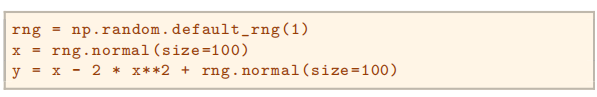

In this data set, what is n and what is p? Write out the model used to generate the data in equation form.

$$
y = -2x^2 + x + \epsilon
$$

In [66]:
rng = np.random.default_rng(1)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)

# n is 100
# p is 2

#### (b)  Create a scatterplot of X against Y . Comment on what you fnd.

<AxesSubplot: >

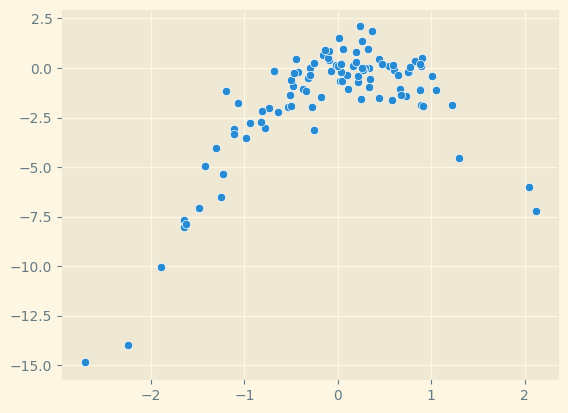

In [67]:
sns.scatterplot(x=x, y=y)

The plot looks like an inverted parabola, as expected

#### (c) Set a random seed, and then compute the LOOCV errors that result from ftting the following four models using least squares:
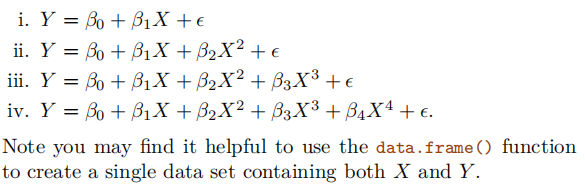

In [137]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression as lr

def scorer(estimator, X, y):
    pred = estimator.predict(X)
    resid = y - pred
    return resid

def try_models(seed=1):
    
    rnd = np.random.default_rng(seed)
    x = rnd.normal(size=100)
    y = x - 2 * x**2 + rnd.normal(size=100)
    
    df_ = pd.DataFrame(np.ones((len(y),1)), columns=["const"])
    df_["x"] = x
    df_["x^2"] = x**2
    df_["x^3"] = x**3
    df_["x^4"] = x**4
    df_["x^5"] = x**5
    
    scores = []
    for i in range(len(df_.columns) - 1):
        folds = KFold(n_splits=len(y))

        res = cross_val_score(lr(),
                             df_[df_.columns[1:i+2]],
                             y,
                             cv=folds,
                             scoring=scorer)
        
        mse = np.array(res).std() ** 2
        scores.append(mse)
        
    return np.array(scores)

In [138]:
scores1 = try_models()
scores1

array([6.63165582, 1.12287638, 1.30061327, 1.33063678, 1.50346854])

#### (d)  Repeat (c) using another random seed, and report your results. Are your results the same as what you got in (c)? Why?

In [139]:
scores1 = try_models(432423)
scores1

array([10.86206356,  1.10853636,  1.15491709,  1.23580509,  1.09332341])

The MSE are quite different. The reason is that LOOCV has high variance, hence changing the noise in the data greatly influenced the estimates.

#### (e) Which of the models in (c) had the smallest LOOCV error? Is this what you expected? Explain your answer.

The second model has the smallest LOOCV error. IT is what we expect since it matches the way the data is generated. The second model models a quadratic, which is the same as the true distribution of y.

#### (f) Comment on the statistical signifcance of the coefcient estimates that results from ftting each of the models in (c) using least squares. Do these results agree with the conclusions drawn based on the cross-validation results?

In [142]:
seed = 123
rnd = np.random.default_rng(seed)
x = rnd.normal(size=100)
y = x - 2 * x**2 + rnd.normal(size=100)

df_ = pd.DataFrame(np.ones((len(y),1)), columns=["const"])
df_["x"] = x
df_["x^2"] = x**2
df_["x^3"] = x**3
df_["x^4"] = x**4
df_["x^5"] = x**5

for i in range(len(df_.columns)):
    model = sm.OLS(y, df_[df_.columns[:i+1]]).fit()
    print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 04 Aug 2023   Prob (F-statistic):                nan
Time:                        18:30:16   Log-Likelihood:                -224.99
No. Observations:                 100   AIC:                             452.0
Df Residuals:                      99   BIC:                             454.6
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4357      0.231     -6.223      0.0

From the t-statistics we see that the x^3, x^4, x^5 variables are not significant, which corroborates with the finding with our LOOCV.

### 9. We will now consider the Boston housing data set, from the ISLP library.
#### (a)  Based on this data set, provide an estimate for the population mean of medv. Call this estimate µˆ.

In [146]:
boston_df = load_data("Boston")
mu = boston_df["medv"].mean()
print("MEDV Population Mean Estimate: ", mu)

MEDV Population Mean Estimate:  22.532806324110677


#### (b) Provide an estimate of the standard error of µ. Interpret this result.

In [148]:
std_hat = boston_df["medv"].std() / len(boston_df)**0.5
print("MEDV Population Mean Standanrd Error :", std_hat)

MEDV Population Mean Standanrd Error : 0.4088611474975351


#### (c) Now estimate the standard error of µ using the bootstrap. How does this compare to your answer from (b)?

In [161]:
medv = boston_df.medv
rnd = np.random.default_rng(42)

samples = 1000
means = np.zeros(samples)

for i in range(samples):
    bootstrap = rnd.choice(medv, size=medv.shape)
    means[i] = bootstrap.mean()
    
std = means.std()
print("Booststrap Mean STD: ", std)

Booststrap Mean STD:  0.40898818361867406


The bootstrap estimate is very near our estimate in part (b).


#### (d) Based on your bootstrap estimate from (c), provide a 95 % confidence interval for the mean of medv. Compare it to the results obtained by using Boston['medv'].std() and the two standard error rule (3.9).

In [163]:
conf_int_bootstrap = [means.mean() - std * 1.96, means.mean() + std * 1.96]
conf_int_ = [mu - std_hat * 1.96, mu + std_hat * 1.96]

print("Booststrap: ", conf_int_bootstrap)
print("Formula: ", conf_int_)

Booststrap:  [21.732057073150877, 23.335290752936082]
Formula:  [21.73143847501551, 23.334174173205845]


#### (e) Based on this data set, provide an estimate, $\hat\mu_{med} $, for the median value of medv in the population.

In [164]:
medv.median()

21.2

#### (f) We now would like to estimate the standard error of µˆmed. Unfortunately, there is no simple formula for computing the standard error of the median. Instead, estimate the standard error of the median using the bootstrap. Comment on your fndings.

In [169]:
rnd = np.random.default_rng(456)

n = 1000
medians = np.zeros(n)

for i in range(n):
    bootstrap = rnd.choice(medv, size=medv.shape)
    
    medians[i] = np.median(bootstrap)
    
med_std = medians.std()
med_std

0.3625797015829757

#### (g) Based on this data set, provide an estimate for the tenth percentile of medv in Boston census tracts. Call this quantity µ0.1. (You can use the np.percentile() function.)

In [171]:
tenth_perc = np.percentile(medv, 10)
tenth_perc

12.75

#### (h) Use the bootstrap to estimate the standard error of µ0.1. Comment on your findings

In [172]:
rnd = np.random.default_rng(456)

n = 1000
percs_10 = np.zeros(n)

for i in range(n):
    bootstrap = rnd.choice(medv, size=medv.shape)
    
    percs_10[i] = np.percentile(bootstrap, 10)
    
percs10_std = percs_10.std()
percs10_std

0.48414584321255927

The 10th percentile has higher variance than the mean and median.